## In-Depth Analysis/ Machine Learning

In [1]:
import pandas as pd
from datetime import datetime
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import scipy.stats as stats

#### Load Data and Prepare for Modelling

In [2]:
loans = pd.read_csv('loans_clean.csv')

In [3]:
dtypes = loans.dtypes
object_vars = list(dtypes[dtypes == 'object'].index)
loans[object_vars] = loans[object_vars].astype('category')
date_vars = ['issue_d', 'earliest_cr_line', 'last_credit_pull_d']
loans.loc[:, date_vars] = loans.loc[:, date_vars].apply(pd.to_datetime, errors='coerce')

In [4]:
high_corr = ['num_actv_rev_tl', 'tot_cur_bal', 'open_acc', 'installment']
drop_cols = ['zip_code','earliest_cr_line', 'last_credit_pull_d', 'issue_d', 'grade', 'loan_status']

In [5]:
loans.drop(high_corr, axis = 1, inplace = True)
loans.drop(drop_cols, axis = 1, inplace = True)

In [6]:
loans_dummy = pd.get_dummies(loans, drop_first = True, dtype = float)
X = loans_dummy.drop('total_pymnt', axis = 1)
y = loans_dummy['total_pymnt']

#### Split Data into Train, Validaton, and  Test Data

In [7]:
from sklearn.model_selection import train_test_split

In [8]:
X_intermediate, X_test, y_intermediate, y_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_train, X_validation, y_train, y_validation = train_test_split(X_intermediate, y_intermediate, test_size = 0.25, random_state = 42)

In [9]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_train_scaler = scaler.fit(X_train)
X_train = X_train_scaler.transform(X_train)
X_validation = X_train_scaler.transform(X_validation)
X_test = X_train_scaler.transform(X_test)

## Baseline Models

First I will run a linear regression, random forest, and gradient boosting model with the defaults and no tuning to get some baseline scores.

I will evaluate performance based on the following metrics:

 - Validation Scores (R^2)

 - Mean Absolute Error (MAE)

 - Root Mean Squared Error (RMSE)

 - Residual plot and histogram.

#### Linear Regression

In [11]:
from sklearn.linear_model import LinearRegression
lr = LinearRegression()
lr.fit(X_train, y_train)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None,
         normalize=False)

In [12]:
lr.intercept_

16165.701662050575

In [13]:
pd.options.display.max_rows = 225
df_coefs = pd.DataFrame(lr.coef_, index=X.columns, columns = ['Coefficient'])
df_coefs['Abs_Coefficient'] = abs(df_coefs.Coefficient)
df_coefs.sort_values('Abs_Coefficient', ascending = False).head(10)
    

,Coefficient,Abs_Coefficient
funded_amnt,9104.816773,9104.816773
int_rate,-705.725175,705.725175
sub_grade_C4,659.777491,659.777491
sub_grade_C5,640.839217,640.839217
sub_grade_C3,608.496163,608.496163
sub_grade_D5,596.138953,596.138953
sub_grade_C2,587.523498,587.523498
sub_grade_D2,581.612250,581.612250
sub_grade_D1,576.083067,576.083067
sub_grade_C1,558.921291,558.921291


In [14]:
from sklearn.metrics import mean_squared_error
lr_predictions = lr.predict(X_validation)
lr_train_score = lr.score(X_train, y_train)
lr_validation_score = lr.score(X_validation, y_validation)
lr_mae = np.mean(abs(lr_predictions - y_validation))
lr_rmse = np.sqrt(mean_squared_error(y_validation, lr_predictions))

In [15]:
print('Base Linear Regression Train Score:      ', lr_train_score)
print('Base Linear Regression Validation Score: ', lr_validation_score)
print('-'*72)
print('Base Linear Regression MAE:              ',lr_mae)
print('Base Linear Regression RMSE:             ',lr_rmse)

Base Linear Regression Train Score:       0.7986467331490279
Base Linear Regression Validation Score:  0.7965032291718208
------------------------------------------------------------------------
Base Linear Regression MAE:               2603.746790849326
Base Linear Regression RMSE:              4762.5961175067805


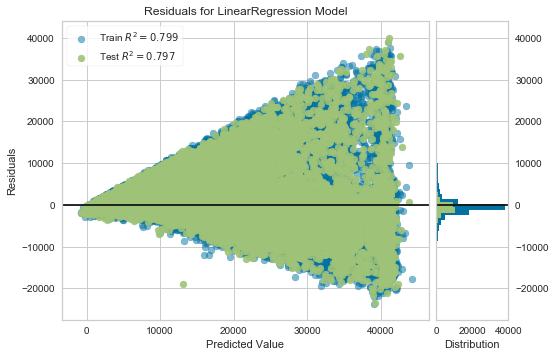

In [16]:
from yellowbrick.regressor import ResidualsPlot
visualizer = ResidualsPlot(lr)
visualizer.fit(X_train, y_train)
visualizer.score(X_validation, y_validation)
visualizer.poof()

The base linear regression model has a score of 0.799 on the training set and 0.797 on the validation set.  The residuals are fairly well centered at around zero on both the training and validation set.

#### Random Forest

For the baseline random forest model, I will run the defaults, with the exception of 'n_estimators', which I will set at 100 which is the default on the current sklearn, but not on the one I am running.

In [17]:
from sklearn.ensemble import RandomForestRegressor
rf = RandomForestRegressor(n_jobs = -1, n_estimators = 100)

rf.fit(X_train, y_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [18]:
rf_predictions = rf.predict(X_validation)
rf_train_score = rf.score(X_train, y_train)
rf_validation_score = rf.score(X_validation, y_validation)
rf_mae = np.mean(abs(rf_predictions - y_validation))
rf_rmse = np.sqrt(mean_squared_error(y_validation, rf_predictions))

In [19]:
print('Base Random Forest Train Score:      ', rf_train_score)
print('Base Random Forest Validation Score: ', rf_validation_score)
print('.'*72)
print('Base Random Forest MAE:              ',rf_mae)
print('Base Random Forest RMSE:             ',rf_rmse)

Base Random Forest Train Score:       0.9707345202103387
Base Random Forest Validation Score:  0.789542629831921
........................................................................
Base Random Forest MAE:               2707.2621792544433
Base Random Forest RMSE:              4843.3634734511215


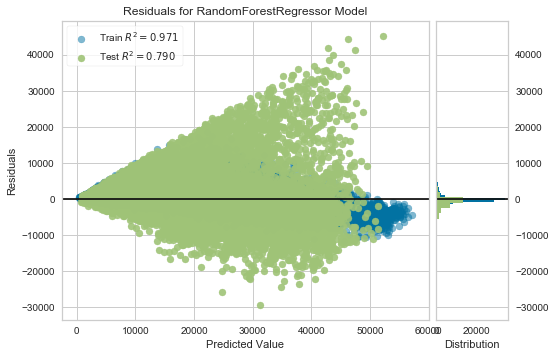

In [20]:
visualizer_rf = ResidualsPlot(rf)
visualizer_rf.fit(X_train, y_train)
visualizer_rf.score(X_validation, y_validation)
visualizer_rf.poof()

In [29]:
feature_importances = pd.DataFrame(rf.feature_importances_, index = X.columns, columns = ['importance']).sort_values('importance', ascending = False)
feature_importances.head(10)

,importance
funded_amnt,0.799174
int_rate,0.012713
mo_sin_old_rev_tl_op,0.007633
mo_sin_old_il_acct,0.007120
dti,0.006973
revol_util,0.006746
annual_inc,0.006354
bc_util,0.006241
tot_hi_cred_lim,0.005559
bc_open_to_buy,0.005396


As expected, the amount of the loan is most importand feature in predicting how much will be repaid.

#### Gradient Boosting

In [21]:
from sklearn.ensemble import GradientBoostingRegressor

In [22]:
boost = GradientBoostingRegressor()
boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=100, n_iter_no_change=None, presort='auto',
             random_state=None, subsample=1.0, tol=0.0001,
             validation_fraction=0.1, verbose=0, warm_start=False)

In [23]:
boost_predictions = boost.predict(X_validation)
boost_train_score = boost.score(X_train, y_train)
boost_validation_score = boost.score(X_validation, y_validation)
boost_mae = np.mean(abs(boost_predictions - y_validation))
boost_rmse = np.sqrt(mean_squared_error(y_validation, boost_predictions))

In [24]:
print('Base Gradient Boost Train Score:     ', boost_train_score)
print('Base Gradient Boost Validation Score:', boost_validation_score)
print('.'*72)
print('Base Gradient Boost MAE:             ', boost_mae)
print('Base Gradient Boost RSME:            ',boost_rmse)

Base Gradient Boost Train Score:      0.8053485377507549
Base Gradient Boost Validation Score: 0.7991738556139931
........................................................................
Base Gradient Boost MAE:              2559.2250247423544
Base Gradient Boost RSME:             4731.241512796871


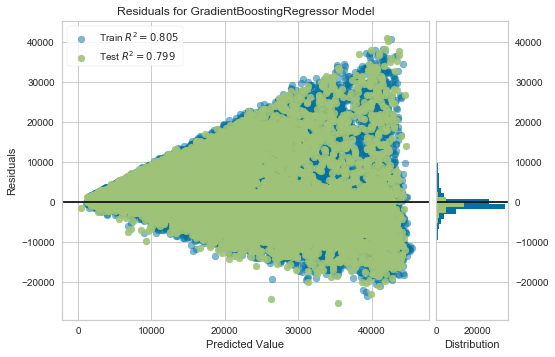

In [26]:
visualizer_boost = ResidualsPlot(boost)
visualizer_boost.fit(X_train, y_train)
visualizer_boost.score(X_validation, y_validation)
visualizer_boost.poof(alpha = 0.01)

#### Summary of all Base Models

In [29]:
print('Base Linear Regression Train Score:      ', lr_train_score)
print('Base Linear Regression Validation Score: ', lr_validation_score)
print('.'*72)
print('Base Linear Regression MAE:              ',lr_mae)
print('Base Linear Regression RMSE:             ',lr_rmse)
print('-'*72)
print('Base Random Forest Train Score:          ', rf_train_score)
print('Base Random Forest Validation Score:     ', rf_validation_score)
print('.'*72)
print('Base Random Forest MAE:                  ',rf_mae)
print('Base Random Forest RMSE:                 ',rf_rmse)
print('-'*72)
print('Base Gradient Boost Train Score:         ', boost_train_score)
print('Base Gradient Boost Validation Score:    ', boost_validation_score)
print('.'*72) 
print('Base Gradient Boost MAE:                 ', boost_mae)
print('Base Gradient Boost RSME:                ',boost_rmse)

Base Linear Regression Train Score:       0.7986467331490279
Base Linear Regression Validation Score:  0.7965032291718208
------------------------------------------------------------------------
Base Linear Regression MAE:               2603.746790849326
Base Linear Regression RMSE:              4762.5961175067805
------------------------------------------------------------------------
Base Random Forest Train Score:           0.9709036335556278
Base Random Forest Validation Score:      0.7903661572241276
------------------------------------------------------------------------
Base Random Forest MAE:                   2700.3460624602567
Base Random Forest RMSE:                  4833.87805588999
------------------------------------------------------------------------
Base Gradient Boost Train Score:          0.8053485377507549
Base Gradient Boost Validation Score:     0.7991265046810226
------------------------------------------------------------------------
Base Gradient Boost MAE:    

Overall, the differences in validation scores, RMSE, and MAE are fairly small.

The Gradient Boost base model is performing the best, with the best validation score, RMSE, and MAE.  The validation score is nearly as high as the training score.

The linear regression is performing the next best based on valdation score, MAE, and RMSE, and it also does not show a large amount of overfitting.

The random forest is overfitting, with both the highest train score and lowest test score.  It also has the highest MAE and RMSE. 


## Model Tuning

#### Linear Regression  Tuning

In [30]:
from sklearn.linear_model import Ridge

In [31]:
alphas = [0.001, 0.01, 0.1, 1, 10, 100, 1000]

for alpha in alphas:
    
    ridge = Ridge(alpha = alpha, fit_intercept = True, random_state = 1)
    ridge.fit(X_train, y_train)
    new_train_error = np.sqrt(mean_squared_error(y_train, ridge.predict(X_train)))
    new_validation_error = np.sqrt(mean_squared_error(y_validation, ridge.predict(X_validation)))
    print('alpha: {:7} | train error: {:5} | val error: {:6}'.
          format(alpha,
                 round(new_train_error,10),
                 round(new_validation_error,10)))
    #print('alpha: ', alpha, ' | train error: ', new_train_error, ' | validation error: ', new_validation_error)

alpha:   0.001 | train error: 4711.6010740235 | val error: 4762.5960943808
alpha:    0.01 | train error: 4711.6010740327 | val error: 4762.5958862812
alpha:     0.1 | train error: 4711.6010749508 | val error: 4762.593808671
alpha:       1 | train error: 4711.6011648097 | val error: 4762.5733659114
alpha:      10 | train error: 4711.6085073334 | val error: 4762.3977013985
alpha:     100 | train error: 4711.809015581 | val error: 4761.7282417211
alpha:    1000 | train error: 4713.9253770971 | val error: 4761.9555792393


In [33]:
ridge = Ridge(alpha = 100)
ridge.fit(X_train, y_train)

Ridge(alpha=100, copy_X=True, fit_intercept=True, max_iter=None,
   normalize=False, random_state=None, solver='auto', tol=0.001)

In [34]:
from sklearn.linear_model import Lasso

In [36]:
alphas = [0.5, 1, 10, 100]

for alpha in alphas:
    
    lasso = Lasso(alpha = alpha, fit_intercept = True, random_state = 1)
    lasso.fit(X_train, y_train)
    new_train_error = np.sqrt(mean_squared_error(y_train, lasso.predict(X_train)))
    new_validation_error = np.sqrt(mean_squared_error(y_validation, lasso.predict(X_validation)))
    print('alpha: {:7} | train error: {:5} | val error: {:6}'.
          format(alpha,
                 round(new_train_error,10),
                 round(new_validation_error,10)))

alpha:     0.5 | train error: 4712.2434331099 | val error: 4761.4565675391
alpha:       1 | train error: 4712.5007862035 | val error: 4761.3387158124
alpha:      10 | train error: 4714.9961028316 | val error: 4761.9118551068
alpha:     100 | train error: 4734.3569114202 | val error: 4780.0057991402


In [37]:
lasso = Lasso(alpha = 1)
lasso.fit(X_train, y_train)

Lasso(alpha=1, copy_X=True, fit_intercept=True, max_iter=1000,
   normalize=False, positive=False, precompute=False, random_state=None,
   selection='cyclic', tol=0.0001, warm_start=False)

In [38]:
print('Base Linear Regression Train Score:      ', lr.score(X_train, y_train))
print('Base Linear Regression Validation Score: ', lr.score(X_validation, y_validation))
print('-'*72)
print('Ridge Regression Train Score:            ', ridge.score(X_train, y_train))
print('Ridge Regression Validation Score:       ', ridge.score(X_validation, y_validation))
print('-'*72)
print('Lasso Regression Train Score:            ', lasso.score(X_train, y_train))
print('Lasso Regression Validaton Score:        ', lasso.score(X_validation, y_validation))

Base Linear Regression Train Score:       0.7986467331490279
Base Linear Regression Validation Score:  0.7965032291718208
------------------------------------------------------------------------
Ridge Regression Train Score:             0.7986289597275488
Ridge Regression Validation Score:        0.796577387813002
------------------------------------------------------------------------
Lasso Regression Train Score:             0.7985698262629352
Lasso Regression Validaton Score:         0.7966106678041543


The lasso regularization with an alpha value of 1 is performing the best on the validation data.

In [39]:
lasso_predictions = lasso.predict(X_validation)
lasso_mae = np.mean(abs(lasso_predictions - y_validation))
lasso_rmse = np.sqrt(mean_squared_error(y_validation, lasso_predictions))

print('Base Linear Regression MAE:   ',lr_mae)
print('Base Linear Regression RMSE:  ',lr_rmse)
print('-'*72)
print('Lasso Regresson MAE:          ',lasso_mae)
print('Lasso Regression RSME:        ', lasso_rmse)

Base Linear Regression MAE:    2603.746790849326
Base Linear Regression RMSE:   4762.5961175067805
------------------------------------------------------------------------
Lasso Regresson MAE:           2601.0878756882917
Lasso Regression RSME:         4761.338715812352


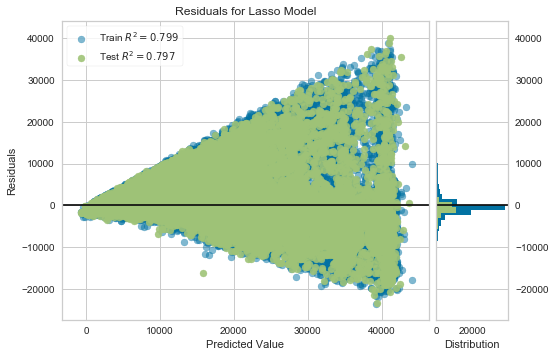

In [40]:
visualizer_lasso = ResidualsPlot(lasso)
visualizer_lasso.fit(X_train, y_train)
visualizer_lasso.score(X_validation, y_validation)
visualizer_lasso.poof()

#### Random Forest Tuning

In [44]:
drop_cols_rf = list(feature_importances[feature_importances.importance < 0.0042].index)
len(drop_cols_rf)

154

In [45]:
X_new = X.drop(drop_cols_rf, axis = 1)

X_new_intermediate, X_new_test, y_new_intermediate, y_new_test = train_test_split(X, y, test_size = 0.2, random_state = 42)

X_new_train, X_new_validation, y_new_train, y_new_validation = train_test_split(X_new_intermediate, y_new_intermediate, test_size = 0.25, random_state = 42)

In [46]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()

X_new_train_scaler = scaler.fit(X_new_train)
X_new_train = X_new_train_scaler.transform(X_new_train)
X_new_validation = X_new_train_scaler.transform(X_new_validation)
X_new_test = X_new_train_scaler.transform(X_new_test)

/anaconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:617: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:6: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:7: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  import sys
/anaconda3/lib/python3.6/site-packages/ipykernel_launcher.py:8: DataConversionWarning: Data with input dtype uint8, float64 were all converted to float64 by StandardScaler.
  


In [47]:
rf_2 = RandomForestRegressor(n_jobs = -1, n_estimators = 100)

rf_2.fit(X_new_train, y_new_train)

RandomForestRegressor(bootstrap=True, criterion='mse', max_depth=None,
           max_features='auto', max_leaf_nodes=None,
           min_impurity_decrease=0.0, min_impurity_split=None,
           min_samples_leaf=1, min_samples_split=2,
           min_weight_fraction_leaf=0.0, n_estimators=100, n_jobs=-1,
           oob_score=False, random_state=None, verbose=0, warm_start=False)

In [48]:
rf_2_predictions = rf_2.predict(X_new_validation)
rf_2_train_score = rf.score(X_new_train, y_new_train)
rf_2_validation_score = rf.score(X_new_validation, y_new_validation)
rf_2_mae = np.mean(abs(rf_2_predictions - y_new_validation))
rf_2_rmse = np.sqrt(mean_squared_error(y_new_validation, rf_2_predictions))

In [49]:
print('Random Forest Reduced Dimension Train Score:      ', rf_2_train_score)
print('Random Forest Reduced Dimension Validation Score: ', rf_2_validation_score)
print('-'*72)
print('Random Forest Reduced Dimension MAE:  ',rf_2_mae)
print('Random Forest Reduced Dimension RMSE: ',rf_2_rmse)

Random Forest Reduced Dimension Train Score:       0.9706827069341555
Random Forest Reduced Dimension Validation Score:  0.7897822700037037
------------------------------------------------------------------------
Random Forest Reduced Dimension MAE:   2701.554450091831
Random Forest Reduced Dimension RMSE:  4840.9322380233225


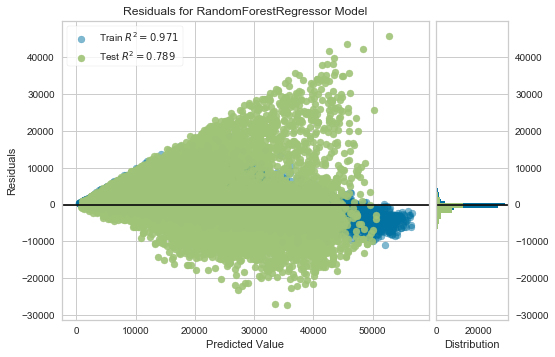

In [50]:
visualizer_rf_2 = ResidualsPlot(rf_2)
visualizer_rf_2.fit(X_new_train, y_new_train)
visualizer_rf_2.score(X_new_validation, y_new_validation)
visualizer_rf_2.poof()

Automatically created module for IPython interactive environment


/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:732: UserWarning: Some inputs do not have OOB scores. This probably means too few trees were used to compute any reliable oob estimates.
  warn("Some inputs do not have OOB scores. "
/ana

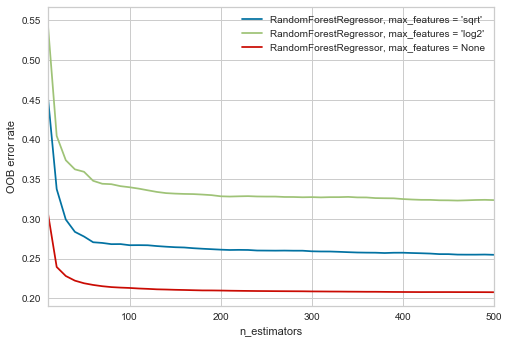

In [51]:
import matplotlib.pyplot as plt

from collections import OrderedDict
from sklearn.ensemble import RandomForestRegressor

# Author: Kian Ho <hui.kian.ho@gmail.com>
#         Gilles Louppe <g.louppe@gmail.com>
#         Andreas Mueller <amueller@ais.uni-bonn.de>
#
# License: BSD 3 Clause

print(__doc__)

random_state = 123

# Generate a binary classification dataset.
#X, y = make_classification(n_samples=500, n_features=25,
#                           n_clusters_per_class=1, n_informative=15,
#                           random_state=RANDOM_STATE)

# NOTE: Setting the `warm_start` construction parameter to `True` disables
# support for parallelized ensembles but is necessary for tracking the OOB
# error trajectory during training.
ensemble_clfs = [
    ("RandomForestRegressor, max_features = 'sqrt'",
        RandomForestRegressor(n_estimators = 100,
                               warm_start = True,
                               oob_score = True,
                               max_features = "sqrt",
                               random_state = random_state,
                               n_jobs = -1)),
    ("RandomForestRegressor, max_features = 'log2'",
        RandomForestRegressor(n_estimators = 100,
                               warm_start = True,
                               max_features = 'log2',
                               oob_score = True,
                               random_state = random_state,
                               n_jobs = -1)),
    ("RandomForestRegressor, max_features = None",
        RandomForestRegressor(n_estimators = 100,
                               warm_start = True,
                               max_features=None,
                               oob_score = True,
                               random_state = random_state,
                               n_jobs = -1))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 500

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 10):
        clf.set_params(n_estimators=i)
        clf.fit(X_new_train, y_new_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [54]:
rf_3 = RandomForestRegressor(n_estimators = 200, max_features = None, n_jobs = -1)

rf_3.fit(X_new_train, y_new_train)

0.9715120314499683
0.7902358536262512


In [56]:
rf_3_predictions = rf_3.predict(X_new_validation)
rf_3_training_score = rf_3.score(X_new_train, y_new_train)
rf_3_validation_score = rf_3.score(X_new_validation, y_new_validation)
rf_3_mae = np.mean(abs(rf_3_predictions - y_new_validation))
rf_3_rmse = np.sqrt(mean_squared_error(y_new_validation, rf_3_predictions))

In [58]:
print(rf_3_training_score)
print(rf_3_validation_score)
print('-'*72)
print(rf_mae)
print(rf_3_rmse)

0.9715120314499683
0.7902358536262512
------------------------------------------------------------------------
2700.3460624602567
4835.380136484394


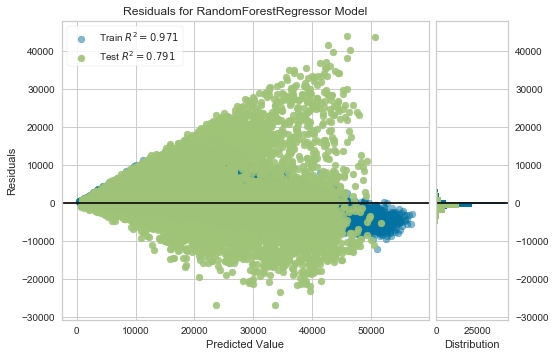

In [59]:
visualizer_rf_3 = ResidualsPlot(rf_3)
visualizer_rf_3.fit(X_new_train, y_new_train)
visualizer_rf_3.score(X_new_validation, y_new_validation)
visualizer_rf_3.poof()

#### Gradient Boost Tuning

In [69]:
ensemble_clfs = [
    ("GradientBoostingRegressor, max_features='sqrt'",
        GradientBoostingRegressor(n_estimators=100,
                               warm_start=True, oob_score=True,
                               max_features="sqrt",
                               random_state=RANDOM_STATE,
                               n_jobs = -1)),
    ("GradientBoostingRegressor, max_features='log2'",
        GradientBoostingRegressor(n_estimators=100,
                               warm_start=True, max_features='log2',
                               oob_score=True,
                               random_state=RANDOM_STATE,
                               n_jobs = -1)),
    ("GradientBoostingRegressor, max_features=None",
        GradientBoostingRegressor(n_estimators=100,
                               warm_start=True, max_features=None,
                               oob_score=True,
                               random_state=RANDOM_STATE,
                               n_jobs = -1))
]

# Map a classifier name to a list of (<n_estimators>, <error rate>) pairs.
error_rate = OrderedDict((label, []) for label, _ in ensemble_clfs)

# Range of `n_estimators` values to explore.
min_estimators = 10
max_estimators = 600

for label, clf in ensemble_clfs:
    for i in range(min_estimators, max_estimators + 1, 10):
        clf.set_params(n_estimators=i)
        clf.fit(X_train, y_train)

        # Record the OOB error for each `n_estimators=i` setting.
        oob_error = 1 - clf.oob_score_
        error_rate[label].append((i, oob_error))

# Generate the "OOB error rate" vs. "n_estimators" plot.
for label, clf_err in error_rate.items():
    xs, ys = zip(*clf_err)
    plt.plot(xs, ys, label=label)

plt.xlim(min_estimators, max_estimators)
plt.xlabel("n_estimators")
plt.ylabel("OOB error rate")
plt.legend(loc="upper right")
plt.show()

In [118]:
boost = GradientBoostingRegressor(n_estimators = 500)
boost.fit(X_train, y_train)

GradientBoostingRegressor(alpha=0.9, criterion='friedman_mse', init=None,
             learning_rate=0.1, loss='ls', max_depth=3, max_features=None,
             max_leaf_nodes=None, min_impurity_decrease=0.0,
             min_impurity_split=None, min_samples_leaf=1,
             min_samples_split=2, min_weight_fraction_leaf=0.0,
             n_estimators=500, presort='auto', random_state=None,
             subsample=1.0, verbose=0, warm_start=False)

In [119]:
print(boost.score(X_train, y_train))
print(boost.score(X_validation, y_validation))

0.08426720608984273
0.02863791879301103
